This notebook is based off of the [second deep learning lesson](https://github.com/fastai/fastai/blob/master/courses/dl1/lesson2-image_models.ipynb)  from fastai 

# Imports, Data Downloads and Paths

In [4]:
from fastai.conv_learner import *
from fastai.other.planet import f2

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

We will be using the data from the kaggle competition [Planet: Understanding the Amazon from Space](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space)

You can download the data using the kaggle pip plugin

```
kaggle competitions download -c planet-understanding-the-amazon-from-space -p \path\to\download\directory -f train-jpg.tar.7z 
kaggle competitions download -c planet-understanding-the-amazon-from-space -p \path\to\download\directory -f test-jpg.tar.7z
kaggle competitions download -c planet-understanding-the-amazon-from-space -p \path\to\download\directory -f test-jpg-additional.tar.7z 
kaggle competitions download -c planet-understanding-the-amazon-from-space -p \path\to\download\directory -f train_v2.csv.zip 
kaggle competitions download -c planet-understanding-the-amazon-from-space -p \path\to\download\directory -f test_v2_file_mapping.csv.zip
```

then unzip the files

In [5]:
PATH = '../data_science/planet/'
!ls {PATH}

__MACOSX      test-jpg.tar.7z		    train-jpg	      train_v2.csv
test-jpg      test_v2_file_mapping.csv	    train-jpg.tar     train_v2.csv.zip
test-jpg.tar  test_v2_file_mapping.csv.zip  train-jpg.tar.7z


# Multi-label versus single-label classification

This is the explanation from [scikit learn's documentation](http://scikit-learn.org/stable/modules/multiclass.html)

- Multiclass classification 
  - Classify an object as belonging to one of mutilple (more than two) classes; e.g., classify a set of images of fruits which may be oranges, apples, or pears. Multiclass classification makes the assumption that each sample is assigned to one and only one label: a fruit can be either an apple or a pear but not both at the same time.

- Multilabel classification 
  - Assign to each sample a set of target labels. This can be thought as predicting properties of a data-point that are not mutually exclusive, such as topics that are relevant for a document. A text might be about any of religion, politics, finance or education at the same time or none of these.

- Multioutput regression 
  - Assigns each sample a set of target values. This can be thought of as predicting several properties for each data-point, such as wind direction and magnitude at a certain location.

- Multioutput-multiclass classification and multi-task classification 
  - A single estimator has to handle several joint classification tasks. This is both a generalization of the multi-label classification task, which only considers binary classification, as well as a generalization of the multi-class classification task. The output format is a 2d numpy array or sparse matrix.

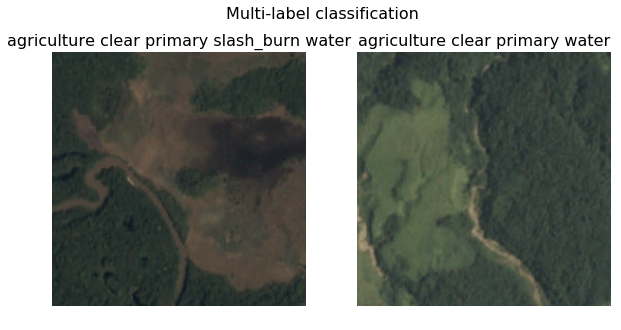

In [4]:
list_paths = [f"{PATH}train-jpg/train_10.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles=["agriculture clear primary slash_burn water", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

# Multi-label models for Planet dataset

In [7]:
metrics=[f2]
f_model = resnet34

In [11]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

We use a different set of data augmentations for this dataset - we also allow vertical flips, since we don't expect vertical orientation of satellite images to change our classifications.

In [7]:
def get_data(sz):
    tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

In [12]:
data = get_data(256)

In [13]:
x,y = next(iter(data.val_dl))

In [16]:
y


    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    1     0     0  ...      0     0     0
       ...          ⋱          ...       
    1     0     0  ...      0     0     1
    0     0     0  ...      0     0     0
    0     0     0  ...      0     0     1
[torch.FloatTensor of size 64x17]

In [17]:
list(zip(data.classes, y[0]))

[('agriculture', 1.0),
 ('artisinal_mine', 0.0),
 ('bare_ground', 0.0),
 ('blooming', 0.0),
 ('blow_down', 0.0),
 ('clear', 1.0),
 ('cloudy', 0.0),
 ('conventional_mine', 0.0),
 ('cultivation', 0.0),
 ('habitation', 0.0),
 ('haze', 0.0),
 ('partly_cloudy', 0.0),
 ('primary', 1.0),
 ('road', 0.0),
 ('selective_logging', 0.0),
 ('slash_burn', 0.0),
 ('water', 1.0)]

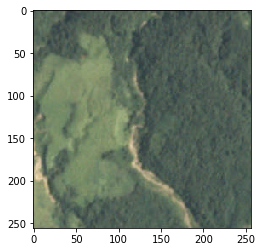

In [24]:
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

In [14]:
sz=64
data = get_data(sz)

In order to not have to resize images which are very large for each batch which takes a lot of time, you can just resize all the images once using the `resize()` method.  This creates a new set of images based on the original images matched o whatever size you specify. 

In [27]:
data = data.resize(int(sz*1.3), 'tmp')

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [28]:
learn = ConvLearner.pretrained(f_model, data, metrics=metrics)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch:   0, train_loss: 0.220683, val_loss: 0.274788, f2: 0.813424



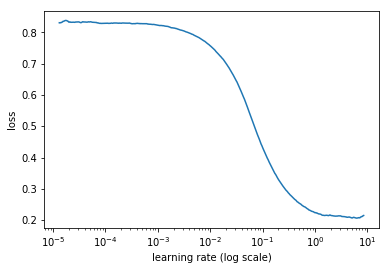

In [29]:
lrf=learn.lr_find()
learn.sched.plot()

In [31]:
lr = 0.2
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch:   0, train_loss: 0.145761, val_loss: 0.136103, f2: 0.877894
epoch:   1, train_loss: 0.140684, val_loss: 0.131713, f2: 0.883109
epoch:   2, train_loss: 0.136533, val_loss: 0.128480, f2: 0.885964
epoch:   3, train_loss: 0.136147, val_loss: 0.129008, f2: 0.884715
epoch:   4, train_loss: 0.138765, val_loss: 0.125908, f2: 0.887878
epoch:   5, train_loss: 0.132445, val_loss: 0.124556, f2: 0.890155
epoch:   6, train_loss: 0.132522, val_loss: 0.124207, f2: 0.890383



In [32]:
lrs = np.array([lr/9,lr/3,lr])

In [34]:
learn.unfreeze()
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

  5%|▌         | 26/506 [00:06<02:02,  3.91it/s, loss=0.159]

Exception in thread Thread-19:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch:   0, train_loss: 0.118472, val_loss: 0.112445, f2: 0.903222
epoch:   1, train_loss: 0.115987, val_loss: 0.108890, f2: 0.906484
epoch:   2, train_loss: 0.106679, val_loss: 0.105551, f2: 0.908446



In [35]:
learn.save(f'{sz}')

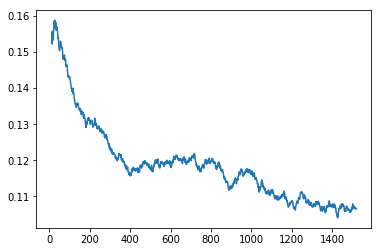

In [36]:
learn.sched.plot_loss()

In [37]:
sz=128

In [38]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch:   0, train_loss: 0.101639, val_loss: 0.100986, f2: 0.913541
epoch:   1, train_loss: 0.102625, val_loss: 0.100340, f2: 0.913283
epoch:   2, train_loss: 0.099884, val_loss: 0.098579, f2: 0.915907
epoch:   3, train_loss: 0.099290, val_loss: 0.100078, f2: 0.913884
epoch:   4, train_loss: 0.098116, val_loss: 0.098724, f2: 0.914995
epoch:   5, train_loss: 0.097830, val_loss: 0.098052, f2: 0.916310
epoch:   6, train_loss: 0.100549, val_loss: 0.098314, f2: 0.916248



In [39]:
learn.unfreeze()
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch:   0, train_loss: 0.094272, val_loss: 0.091868, f2: 0.922287
epoch:   1, train_loss: 0.095355, val_loss: 0.091301, f2: 0.922834
epoch:   2, train_loss: 0.090224, val_loss: 0.088858, f2: 0.925478



In [23]:
sz=256

In [24]:
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

A Jupyter Widget

[ 0.       0.09161  0.08651  0.92712]                         
[ 1.       0.08933  0.08665  0.92677]                         
[ 2.       0.09125  0.08584  0.92719]                         
[ 3.       0.08732  0.08532  0.92812]                         
[ 4.       0.08736  0.08479  0.92854]                         
[ 5.       0.08807  0.08471  0.92835]                         
[ 6.       0.08942  0.08448  0.9289 ]                         



In [25]:
learn.unfreeze()
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}')

A Jupyter Widget

[ 0.       0.08932  0.08218  0.9324 ]                         
[ 1.       0.08654  0.08195  0.93313]                         
[ 2.       0.08468  0.08024  0.93391]                         
[ 3.       0.08596  0.08141  0.93287]                         
[ 4.       0.08211  0.08152  0.93401]                         
[ 5.       0.07971  0.08001  0.93377]                         
[ 6.       0.07928  0.0792   0.93554]                         



In [40]:
log_preds,y = learn.TTA()
preds = np.mean(np.exp(log_preds),0)

In [41]:
f2(preds,y)

0.4839434774136777

### End